<img src="https://www.th-koeln.de/img/logo.svg" style="float:right;" width="200">

# 4th exercise: <font color="#C70039">Random Walk Forecast </font>
* Course: <a href="https://www.gernotheisenberg.de/time_series_forecasting.html">Time Series Forecasting (TSF)</a>
* Lecturer: <a href="https://www.gernotheisenberg.de/uebermich.html">Gernot Heisenberg</a>
* Date:   25.02.2025

<img src="./images/random_walk.png" style="float: center;" width="450">

---------------------------------
**GENERAL NOTE 1**: 
Please make sure you are reading the entire notebook, since it contains a lot of information on your tasks (e.g. regarding the set of certain paramaters or a specific computational trick), and the written mark downs as well as comments contain a lot of information on how things work together as a whole. 

**GENERAL NOTE 2**: 
* Please, when commenting source code, just use English language only. 
* When describing an observation please use English language, too
* This applies to all exercises throughout this course.  

---------------------

### <font color="ce33ff">DESCRIPTION OF THE NOTEBOOK CONTENT</font>:
This notebook allows you for creating a random walk series and develop the best forecasting model for this process. 

-------------------------------------------------------------------------------------------------------------

### <font color="FFC300">TASKS</font>:
The tasks that you need to work on within this notebook are always indicated below as bullet points. 
If a task is more challenging and consists of several steps, this is indicated as well. 
Make sure you have worked down the task list and commented your doings. 
This should be done by using markdown.<br> 
<font color=red>Make sure you don't forget to specify your name and your matriculation number in the notebook.</font>

**YOUR TASKS in this exercise are as follows**:
1. import the notebook to Google Colab or use your local machine.
2. make sure you specified you name and your matriculation number in the header below my name and date. 
    * set the date too and remove mine.
3. read the entire notebook carefully 
    * add comments whereever you feel it necessary for better understanding
    * run the notebook for the first time.
    * understand the output
4. Create your own random walk time series data set and forecast it by stepping through the following sequence:
    * Generate a random walk of 500 timesteps. Feel free to choose an initial value different from 0
    * Also, make sure you change the seed by passing a different integer to np.random.seed()
    * Plot your simulated random walk
    * Test for stationarity
    * Apply a first-order difference
    * 5 Test for stationarity
    * Split your simulated random walk into a train set containing the first 400 timesteps. The remaining 100 timesteps will be your test set.
    * Apply different naive forecasting methods and measure the MSE. Which method yields the lowest MSE?
    * Plot your forecasts.
    * Forecast the next timestep over the test set and measure the MSE. Did it decrease?
    * Plot your forecasts.

-----------------------------------------------------------------------------------

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Get some random walk example data 
### Close price of GOOGLE stock from April 28th, 2020 until April 27th, 2021

In [19]:
# get the data
df = pd.read_csv('./data/google_close_price.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-04-27,1292.000000,1294.099976,1265.060059,1270.859985,1270.859985,2209300
1,2020-04-28,1283.199951,1284.760010,1230.380005,1232.589966,1232.589966,4035000
2,2020-04-29,1345.000000,1360.150024,1326.729980,1342.180054,1342.180054,5417900
3,2020-04-30,1331.359985,1350.000000,1321.500000,1346.699951,1346.699951,2792100
4,2020-05-01,1324.089966,1351.430054,1309.660034,1317.319946,1317.319946,2443600


### Visualize the raw data

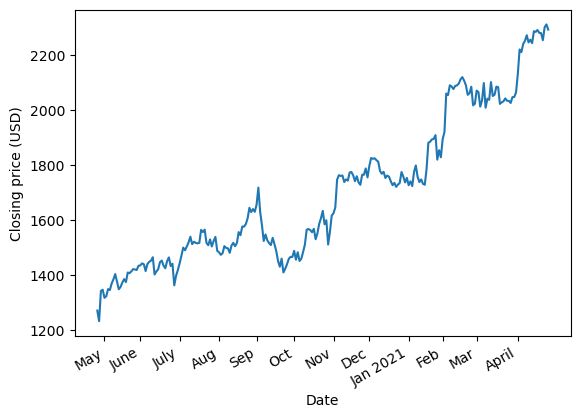

In [20]:
fig, ax = plt.subplots()

ax.plot(df['Date'], df['Close'])
ax.set_xlabel('Date')
ax.set_ylabel('Closing price (USD)')

plt.xticks(
    [4, 24, 46, 68, 89, 110, 132, 152, 174, 193, 212, 235], 
    ['May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2021', 'Feb', 'Mar', 'April'])

fig.autofmt_xdate()

## Section I: Getting used to random walks and its features
### Preparatory work: Create a random walk time series artificially

In [21]:
np.random.seed(42)

steps = np.random.standard_normal(1000)
steps[0]=0

random_walk = np.cumsum(steps)

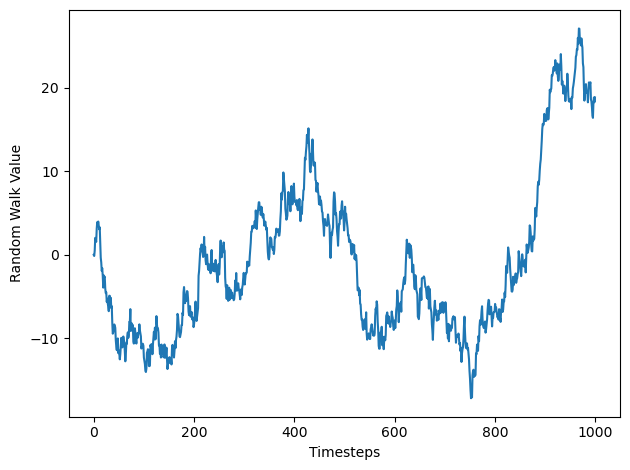

In [22]:
# visualize the random walk time series
fig, ax = plt.subplots()

ax.plot(random_walk)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Random Walk Value')
plt.tight_layout()

### Now, test for stationarity 

In [23]:
def simulate_process(is_stationary: bool) -> np.array:
    np.random.seed(42)
    process = np.empty(400)
    
    if is_stationary:
        alpha = 0.5
        process[0] = 0
    else:
        alpha = 1
        process[0] = 10
        
    for i in range(400):
        if i+1 < 400:
            process[i+1] = alpha*process[i] + np.random.standard_normal()
        else:
            break
        
    return process

In [24]:
stationary = simulate_process(True)
non_stationary = simulate_process(False)

### Visulize the two different time series (stationary vs non-stationary)
observe the difference

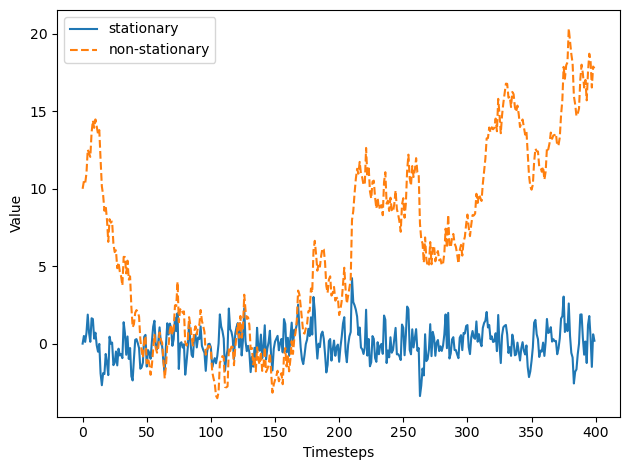

In [25]:
fig, ax = plt.subplots()

ax.plot(stationary, linestyle='-', label='stationary')
ax.plot(non_stationary, linestyle='--', label='non-stationary')
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')
ax.legend(loc=2)
plt.tight_layout()

In [26]:
def mean_over_time(process: np.array) -> np.array:
    mean_func = []
    
    for i in range(len(process)):
        mean_func.append(np.mean(process[:i]))
    
    return mean_func

In [27]:
stationary_mean = mean_over_time(stationary)
non_stationary_mean = mean_over_time(non_stationary)

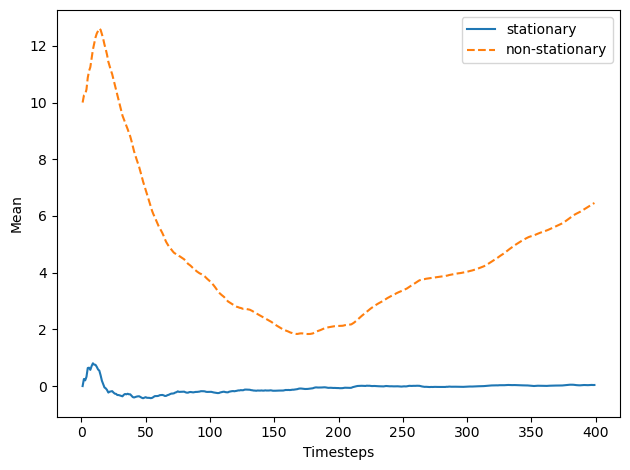

In [28]:
fig, ax = plt.subplots()

ax.plot(stationary_mean, label='stationary')
ax.plot(non_stationary_mean, linestyle='--', label='non-stationary')
ax.set_xlabel('Timesteps')
ax.set_ylabel('Mean')
ax.legend(loc=1)
plt.tight_layout()

In [29]:
def var_over_time(process: np.array) -> np.array:
    var_func = []
    
    for i in range(len(process)):
        var_func.append(np.var(process[:i]))
    
    return var_func

In [30]:
stationary_var = var_over_time(stationary)
non_stationary_var = var_over_time(non_stationary)

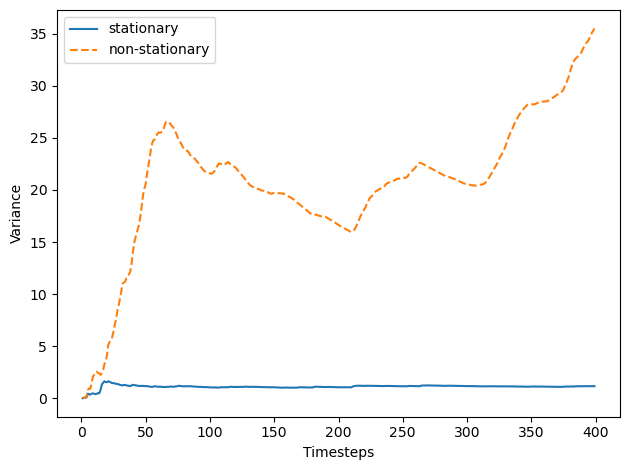

In [31]:
fig, ax = plt.subplots()

ax.plot(stationary_var, label='stationary')
ax.plot(non_stationary_var, linestyle='--', label='non-stationary')
ax.set_xlabel('Timesteps')
ax.set_ylabel('Variance')
ax.legend(loc=2)
plt.tight_layout()

## Section II: Modeling preparation
Now, that you have a good intuition what a random walk time series looks like and what its features are, let us start the modeling process and put it all together. 

#### Stationarity check
First, do the Augmented Dickey-Fuller (ADF) test:
It helps to determine if a time series is stationary by testing for the presence of a unit root. If a unit root is present, the time series is not stationary (see slides).

The null hypothesis, stating that a unit root is present, means that the series is not stationary.

If the test returns a p-value less than a certain significance level, typically 0.05
or 0.01, then we can reject the null hypothesis, meaning that there are no unit roots
and so the series is stationary.

In [15]:
ADF_result = adfuller(random_walk)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -0.9659524876918751
p-value: 0.7654789696692581


#### Autocorrelation function

Once a process is stationary, plotting the autocorrelation function (ACF) is a great way to understand what type of process you are analyzing. In this case, use it to determine if the time series at hand is a random walk or not.

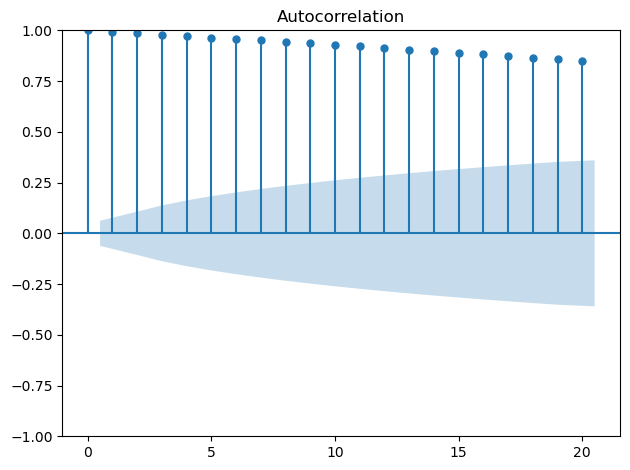

In [16]:
plot_acf(random_walk, lags=20);
plt.tight_layout()

#### Time series processing
Do first order differencing in order to make the time series stationary. Then perform the above steps again.

In [17]:
diff_random_walk = np.diff(random_walk, n=1)

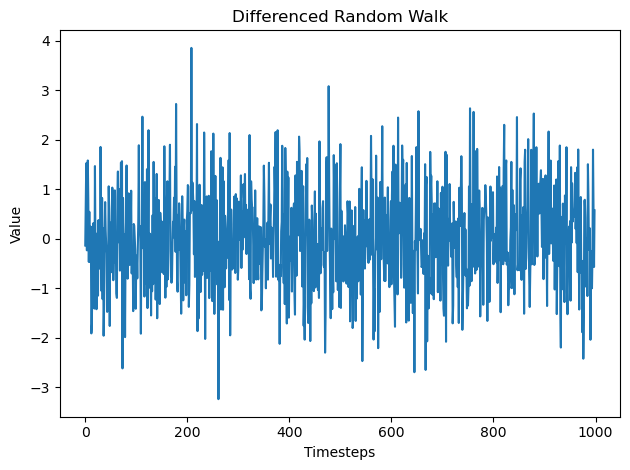

In [18]:
plt.plot(diff_random_walk)
plt.title('Differenced Random Walk')
plt.xlabel('Timesteps')
plt.ylabel('Value')
plt.tight_layout()

In [19]:
ADF_result = adfuller(diff_random_walk)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -31.789310857560615
p-value: 0.0


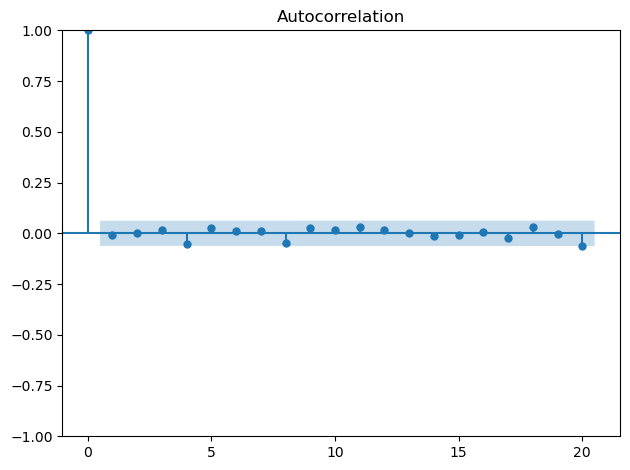

In [20]:
plot_acf(diff_random_walk, lags=20);
plt.tight_layout()

## Section III - Check Google close price series
Apply the above learned steps and check whether or not the close price time series of Google is a random walk. 

In [19]:
GOOGL_ADF_result = adfuller(df['Close'])

print(f'ADF Statistic: {GOOGL_ADF_result[0]}')
print(f'p-value: {GOOGL_ADF_result[1]}')

ADF Statistic: 0.1602504866477145
p-value: 0.9699419435913058


Since it seems 'NO', apply first order differencing to the close price and check again.

In [20]:
diff_close = np.diff(df['Close'], n=1)

In [21]:
GOOGL_diff_ADF_result = adfuller(diff_close)

print(f'ADF Statistic: {GOOGL_diff_ADF_result[0]}')
print(f'p-value: {GOOGL_diff_ADF_result[1]}')

ADF Statistic: -5.303439704295221
p-value: 5.386530961454919e-06


'YES'
Now, check the autocorrelation by plotting it.

First, visualize the 1st order differenced Google Close price chart 

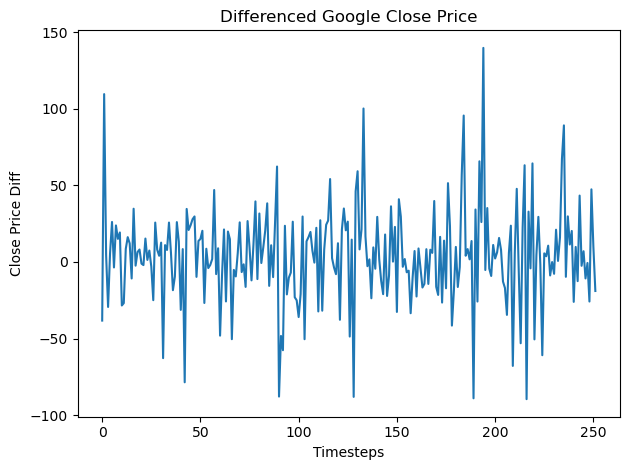

In [25]:
plt.plot(diff_close)
plt.title('Differenced Google Close Price')
plt.xlabel('Timesteps')
plt.ylabel('Close Price Diff')
plt.tight_layout()

Then, visualize the ACF of the 1st order differenced Google Close price chart 

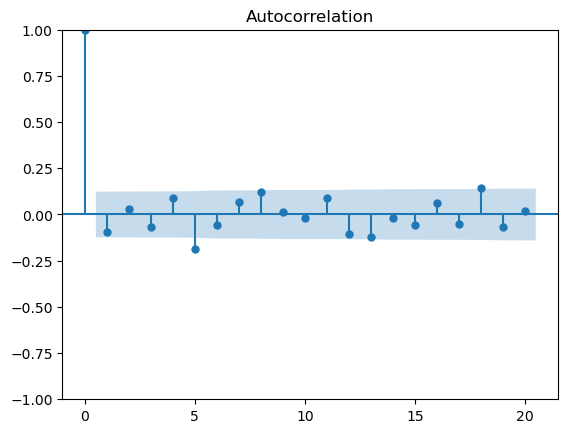

In [22]:
plot_acf(diff_close, lags=20);

As comparison, visualize the ACF of the original, hence undifferenced Google Close price chart 

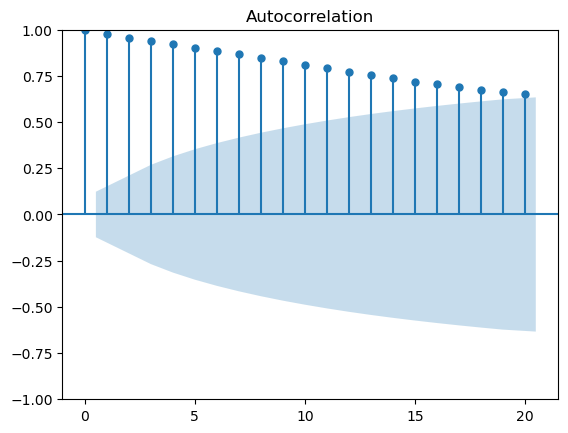

In [23]:
plot_acf(df['Close'], lags=20);

## Section IV - Develop a random walk model
Now, you are ready to do the modeling of the random walk

#### Split off the last 800 values, for testing the forecasting performance of the model

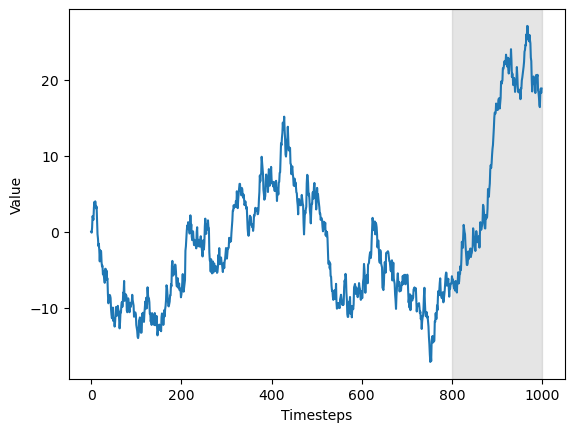

In [25]:
df = pd.DataFrame({'value': random_walk})

# split the training and testing data set
train = df[:800]
test = df[800:]

# visualize the data
fig, ax = plt.subplots()

ax.plot(random_walk)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')
ax.axvspan(800, 1000, color='#808080', alpha=0.2)

#### Create the baseline models

In [26]:
mean = np.mean(train.value)
test.loc[:, 'pred_mean'] = mean
test.head()

,value,pred_mean
800,-5.876664,-3.677206
801,-6.392708,-3.677206
802,-6.296588,-3.677206
803,-6.758863,-3.677206
804,-7.193359,-3.677206


In [27]:
last_value = train.iloc[-1].value
test.loc[:, 'pred_last'] = last_value
test.head()

,value,pred_mean,pred_last
800,-5.876664,-3.677206,-6.814947
801,-6.392708,-3.677206,-6.814947
802,-6.296588,-3.677206,-6.814947
803,-6.758863,-3.677206,-6.814947
804,-7.193359,-3.677206,-6.814947


In [28]:
deltaX = 800 - 1
deltaY = last_value - 0

drift = deltaY / deltaX
x_vals = np.arange(801, 1001, 1)
pred_drift = drift * x_vals

test.loc[:, 'pred_drift'] = pred_drift
test.head()

,value,pred_mean,pred_last,pred_drift
800,-5.876664,-3.677206,-6.814947,-6.832006
801,-6.392708,-3.677206,-6.814947,-6.840536
802,-6.296588,-3.677206,-6.814947,-6.849065
803,-6.758863,-3.677206,-6.814947,-6.857594
804,-7.193359,-3.677206,-6.814947,-6.866124


#### Visualize the baseline models

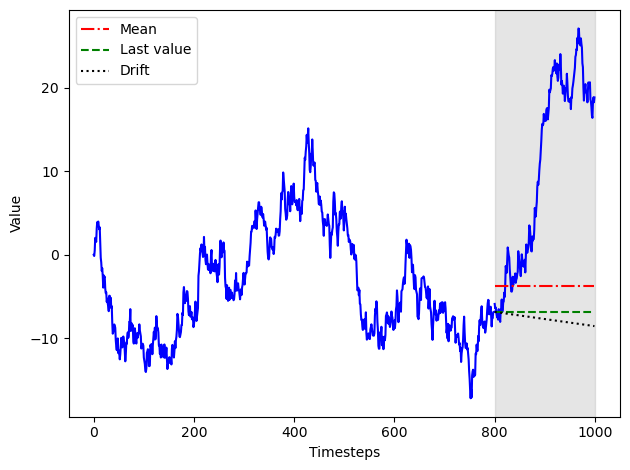

In [29]:
fig, ax = plt.subplots()

ax.plot(train.value, 'b-')
ax.plot(test['value'], 'b-')
ax.plot(test['pred_mean'], 'r-.', label='Mean')
ax.plot(test['pred_last'], 'g--', label='Last value')
ax.plot(test['pred_drift'], 'k:', label='Drift')

ax.axvspan(800, 1000, color='#808080', alpha=0.2)
ax.legend(loc=2)

ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

plt.tight_layout()

#### Measure the performance of the baseline models

In [30]:
from sklearn.metrics import mean_squared_error

mse_mean  = mean_squared_error(test['value'], test['pred_mean'])
mse_last  = mean_squared_error(test['value'], test['pred_last'])
mse_drift = mean_squared_error(test['value'], test['pred_drift'])

print(mse_mean, mse_last, mse_drift)

326.50277395297474 425.1726033055617 466.2172769077409


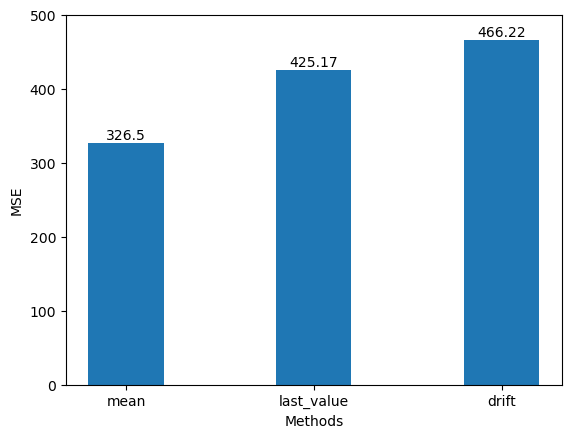

In [31]:
fig, ax = plt.subplots()

x = ['mean', 'last_value', 'drift']
y = [mse_mean, mse_last, mse_drift]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 500)

for index, value in enumerate(y):
    plt.text(x=index, y=value+5, s=str(round(value, 2)), ha='center')

### Forecasting model
Simply shift the time series by 1. Hence, the previous value become the new value 

In [32]:
df_shift = df.shift(periods=1)
df_shift.head()

,value
0,NaN
1,0.000000
2,-0.138264
3,0.509424
4,2.032454


#### Visualize the new and the actual time series and compare them. 
It is very common to use a scatterplot instead.

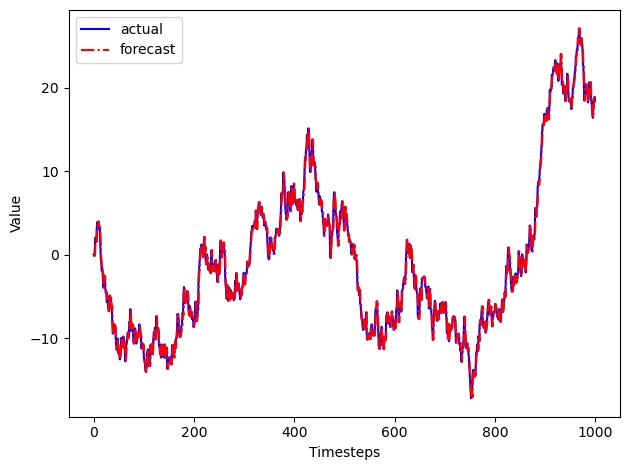

In [33]:
fig, ax = plt.subplots()

ax.plot(df, 'b-', label='actual')
ax.plot(df_shift, 'r-.', label='forecast')

ax.legend(loc=2)

ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

plt.tight_layout()

#### Measure the performance of the shift-by-one-time-step model

In [34]:
mse_one_step = mean_squared_error(test['value'], df_shift[800:])
mse_one_step

0.9256876651440581

#### Visualize again a smaller part for better visual inspection of the reached accuracy.

Text(0, 0.5, 'Value')

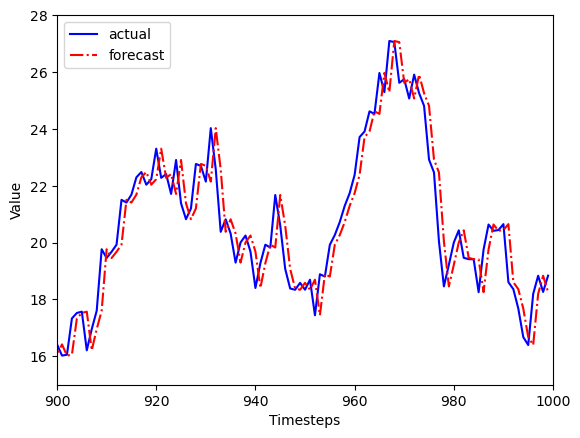

In [35]:
fig, ax = plt.subplots()

ax.plot(df, 'b-', label='actual')
ax.plot(df_shift, 'r-.', label='forecast')

ax.legend(loc=2)

ax.set_xlim(900, 1000)
ax.set_ylim(15, 28)

ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')